In [ ]:
# import thư viện cần thiết
import pandas as pd
import numpy as np
import math
import keras
import joblib
import seaborn as sns
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error

In [ ]:
# Đọc dữ liệu
data = pd.read_csv("WineQT.csv")

In [ ]:
# Xem 5 dòng dữ liệu đầu tiên
data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [ ]:
# Xem thông tin tập dữ liệu
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [ ]:
# Xem tóm tắt thống kê dữ liệu ở dạng chiều ngang
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1143.0,8.311111,1.747595,4.60000,7.10000,7.90000,9.100000,15.90000
volatile acidity,1143.0,0.531339,0.179633,0.12000,0.39250,0.52000,0.640000,1.58000
citric acid,1143.0,0.268364,0.196686,0.00000,0.09000,0.25000,0.420000,1.00000
residual sugar,1143.0,2.532152,1.355917,0.90000,1.90000,2.20000,2.600000,15.50000
chlorides,1143.0,0.086933,0.047267,0.01200,0.07000,0.07900,0.090000,0.61100
free sulfur dioxide,1143.0,15.615486,10.250486,1.00000,7.00000,13.00000,21.000000,68.00000
total sulfur dioxide,1143.0,45.914698,32.782130,6.00000,21.00000,37.00000,61.000000,289.00000
density,1143.0,0.996730,0.001925,0.99007,0.99557,0.99668,0.997845,1.00369
pH,1143.0,3.311015,0.156664,2.74000,3.20500,3.31000,3.400000,4.01000
sulphates,1143.0,0.657708,0.170399,0.33000,0.55000,0.62000,0.730000,2.00000


# Trực quan dữ liệu

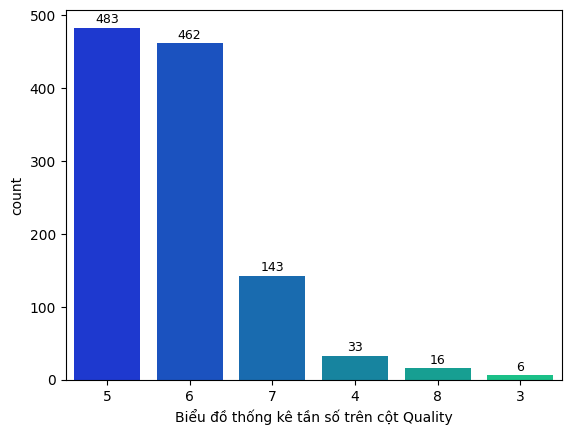

In [ ]:
# Biểu đồ thống kê tần số xuất hiện trên cột quality
def visualize_quality():
  target = data['quality']
  sns.countplot(x = target, palette= 'winter', order = target.value_counts().index)
  plt.xlabel('Biểu đồ thống kê tần số trên cột Quality')

  df = target.value_counts().values
  for i in range(len(target.value_counts().values)):
    plt.text(x = i,y = df[i]+2,s = df[i],size = 9, ha='center', va='bottom')

visualize_quality()

# Nhận xét
# Có thể thấy các nhãn 3,4,8 chỉ chiếm khoảng 6% trong tập dữ liệu => nhãn hiếm.
# Và phần lớn các nhãn là 5 và 6 (khoảng 80%) => mất cân bằng.

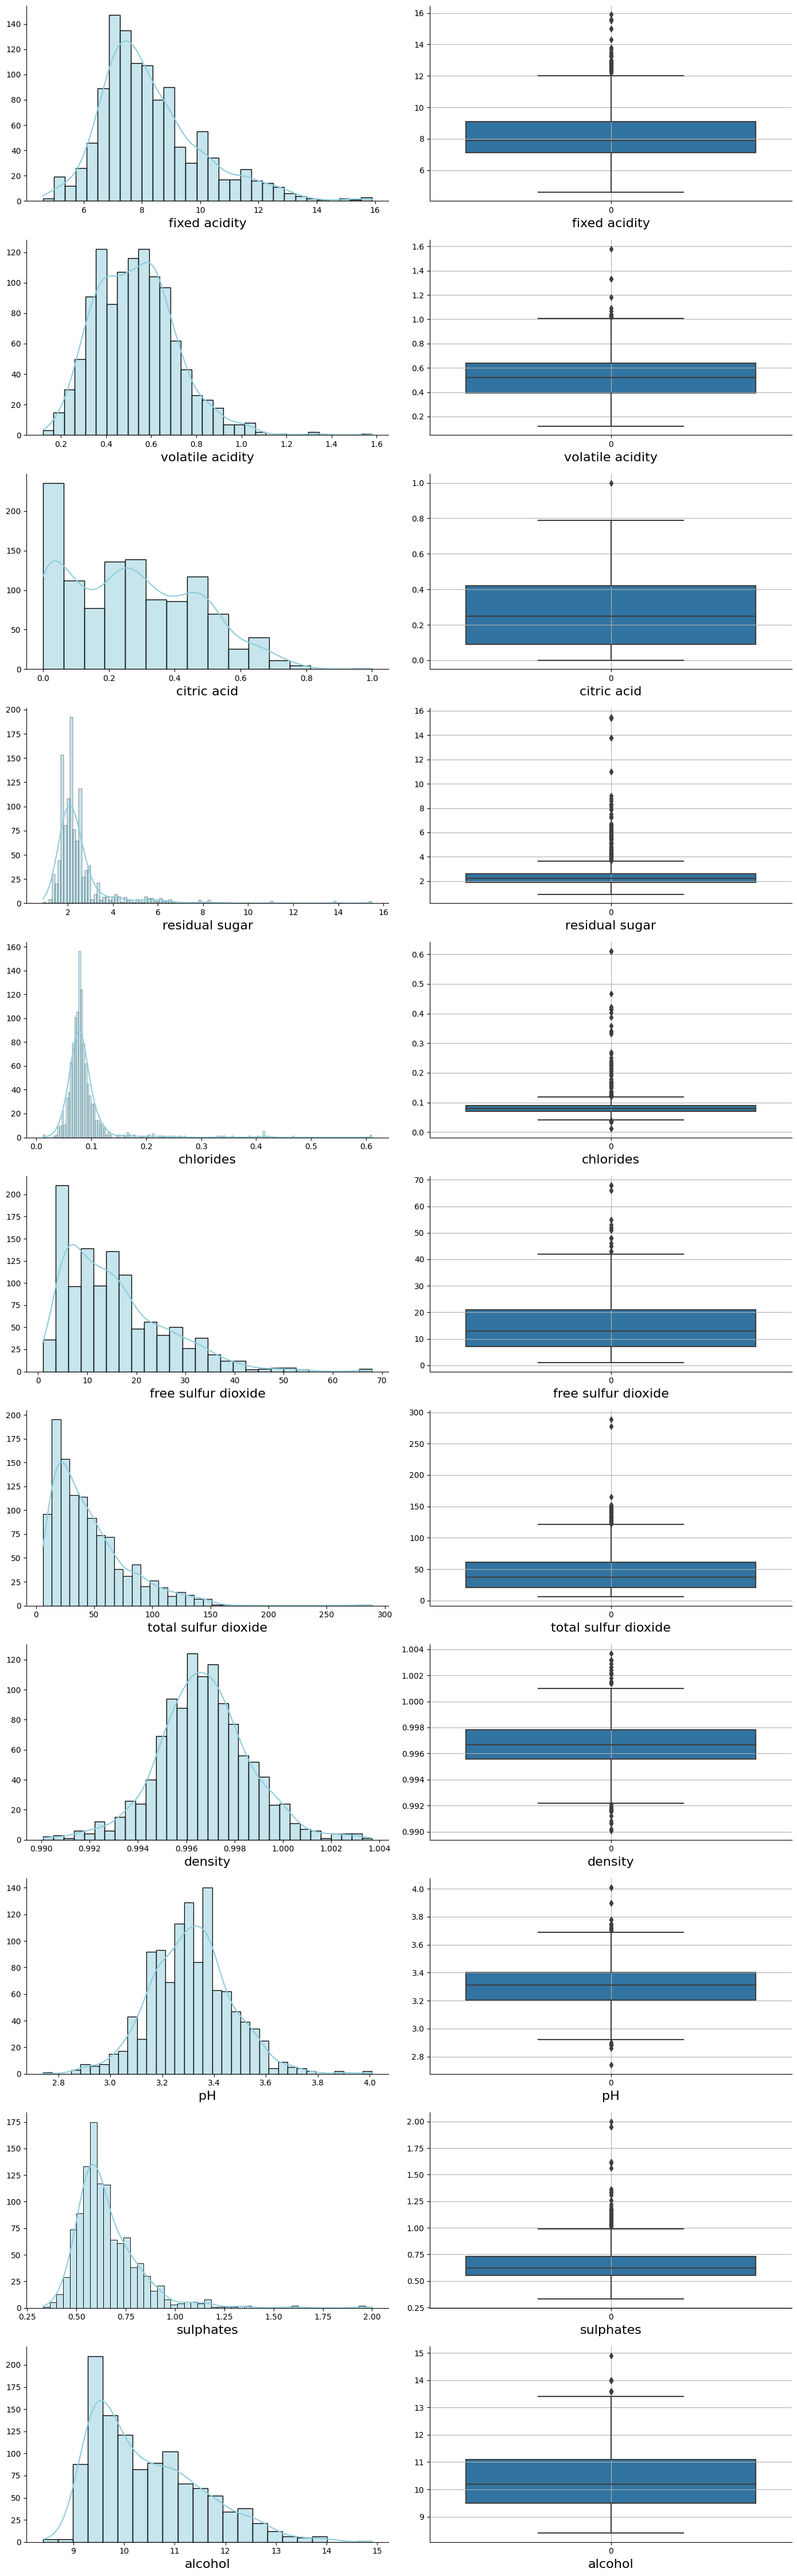

In [ ]:
# Biểu đồ histogram và boxplot cho các biến giải thích
def plot_num_dist(data, target):

    plt.figure(figsize=(14, 45))

    for index, feature in enumerate(data.columns):
        mean = data[feature].mean()
        std = data[feature].std()

        plt.subplot(11, 2, index * 2 + 1)
        sns.histplot(data=data, x=feature, kde=True, color='#8ECDDD')
        plt.xlabel(feature, fontsize=16)
        plt.ylabel('')

        plt.subplot(11, 2, index * 2 + 2)
        sns.boxplot(data=data[feature])#(data=pd.concat([data, target], axis=1), x=target, y=feature, palette='Blues_r')
        plt.xlabel(feature, fontsize=16)
        plt.ylabel('')
        plt.grid(True)

        sns.despine(right=True, top=True)

    plt.tight_layout()
    plt.show()

plot_num_dist(data.iloc[:,:-2], data['quality'])

# Nhận xét
# Dữ liệu được phân phối đa phần lệch phải. Và có nhiều giá trị ngoại lai có trong tập dữ liệu.

<Axes: >

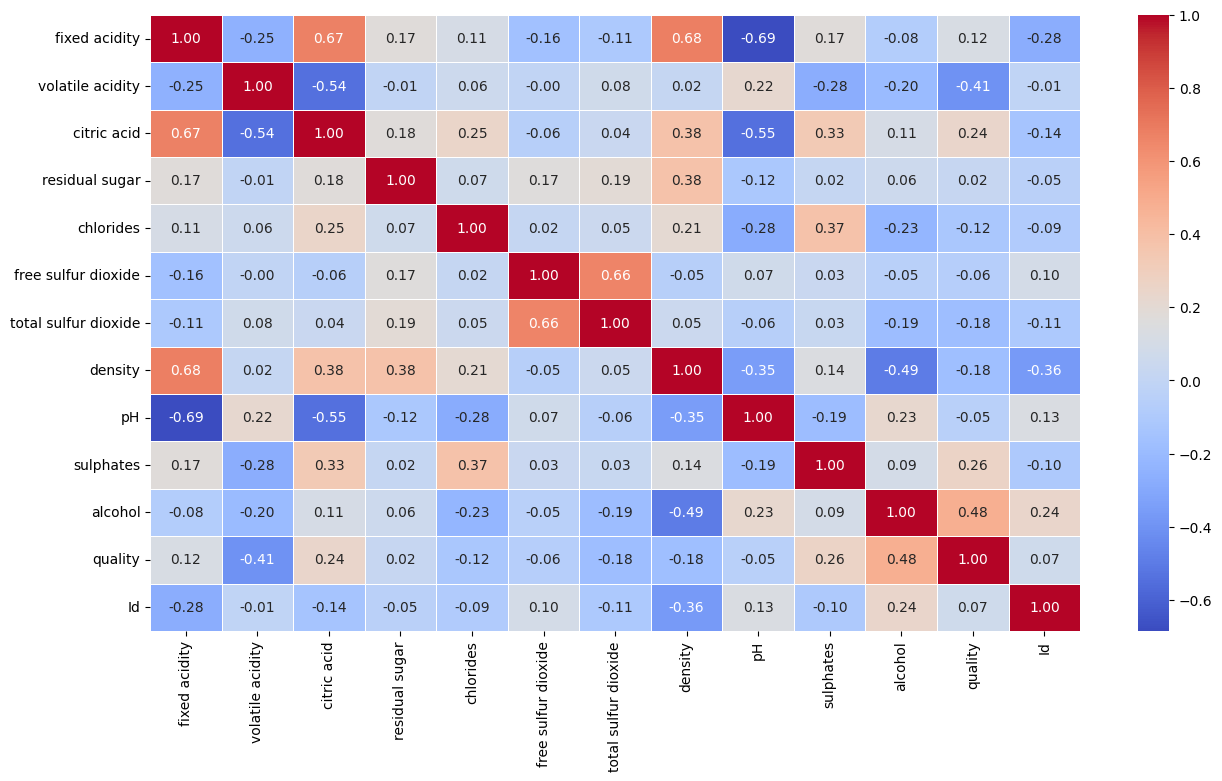

In [ ]:
# Tính ma trận tương quan
correlation_matrix = data.corr()

# Ma trận tương quan
plt.figure(figsize=(15,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Nhận xét
# total sulphur dioxide và free sulphur dioxide có mối tương quan cao.
# Trừ: Nếu quan tâm đến lượng sulfur dioxide đã kết hợp trong mẫu rượu và muốn đo lường mức độ tồn tại của sulfur dioxide đã kết hợp độc lập với lượng sulfur dioxide tự do. Cột mới sẽ biểu thị lượng sulfur dioxide đã kết hợp trong mẫu rượu.
# Cộng: Nếu quan tâm đến tổng lượng sulfur dioxide trong mẫu rượu, bao gồm cả lượng sulfur dioxide tự do và lượng sulfur dioxide đã kết hợp.

# fixed acidity, pH và citric acid có mối tương quan cao.
# fixed acidity và density có mối tương quan dương cao.
# alcohol và density cũng có mối tương quan cao.

# Quản lý dữ liệu

In [ ]:
# Xóa cột Id không cần thiết trong việc phân tích và dự đoán
data = data.drop(columns='Id', axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


In [ ]:
# Kiểm tra giá trị thiếu
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [ ]:
# Hiển thị các dòng trùng lặp
duplicate_rows = data[data.duplicated()]
print("Số lượng dữ liệu bị trùng lặp: ",data.duplicated().sum())
print("\n")
duplicate_rows

Số lượng dữ liệu bị trùng lặp:  125




,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
46,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.99620,3.41,0.39,10.9,5
64,8.6,0.490,0.28,1.90,0.110,20.0,136.0,0.99720,2.93,1.95,9.9,6
65,7.7,0.490,0.26,1.90,0.062,9.0,31.0,0.99660,3.39,0.64,9.6,5
71,8.1,0.545,0.18,1.90,0.080,13.0,35.0,0.99720,3.30,0.59,9.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
1076,7.5,0.380,0.57,2.30,0.106,5.0,12.0,0.99605,3.36,0.55,11.4,6
1113,7.8,0.600,0.26,2.00,0.080,31.0,131.0,0.99622,3.21,0.52,9.9,5
1114,7.8,0.600,0.26,2.00,0.080,31.0,131.0,0.99622,3.21,0.52,9.9,5
1116,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5


In [ ]:
# Xoá các dòng trùng lặp
data = data.drop_duplicates()
print("Số lượng dữ liệu bị trùng lặp: ",data.duplicated().sum())

Số lượng dữ liệu bị trùng lặp:  0


In [ ]:
# Định nghĩa biến SO2 từ 2 biến total sulfur dioxide và free sulfur dioxide
data['SO2'] = data['total sulfur dioxide'] - data['free sulfur dioxide']

data = data.drop('total sulfur dioxide', axis=1)
data = data.drop('free sulfur dioxide', axis=1)

In [ ]:
# Chuyển cột 'SO2' lên vị trí trước 'quality'
cols = list(data.columns)
cols.remove('SO2')
cols.insert(cols.index('quality'), 'SO2')
data = data[cols]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1018 entries, 0 to 1142
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fixed acidity     1018 non-null   float64
 1   volatile acidity  1018 non-null   float64
 2   citric acid       1018 non-null   float64
 3   residual sugar    1018 non-null   float64
 4   chlorides         1018 non-null   float64
 5   density           1018 non-null   float64
 6   pH                1018 non-null   float64
 7   sulphates         1018 non-null   float64
 8   alcohol           1018 non-null   float64
 9   SO2               1018 non-null   float64
 10  quality           1018 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 95.4 KB


In [ ]:
# Gom lại các điểm thành 3 phân loại
data.loc[(data['quality'] >= 3) & (data['quality'] <= 4), 'quality'] = 0
data.loc[(data['quality'] >= 5) & (data['quality'] <= 6), 'quality'] = 1
data.loc[(data['quality'] >= 7) & (data['quality'] <= 8), 'quality'] = 2

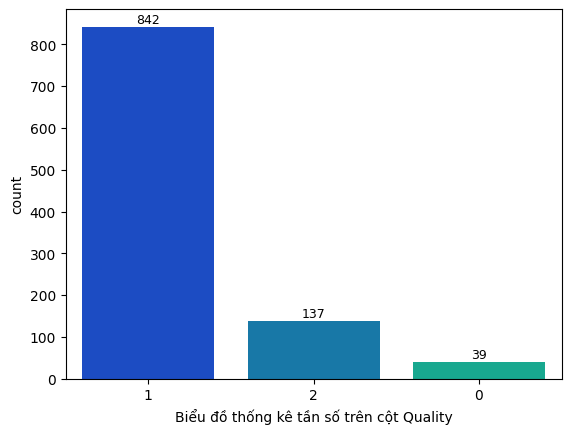

In [ ]:
visualize_quality()

# Cân bằng dữ liệu

In [ ]:
# Cân bằng dữ liệu nhóm thiểu số
os = RandomOverSampler(sampling_strategy={0: 842, 1: 842, 2: 842}, random_state = 42)
X = data.drop(['quality'], axis=1)
y = data['quality']
X_res,y_res = os.fit_resample(X,y)

In [ ]:
# Tạo DataFrame từ X_over và y_over
data = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)

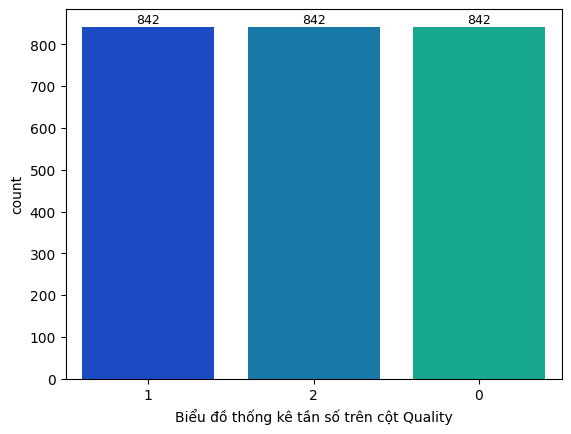

In [ ]:
visualize_quality()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526 entries, 0 to 2525
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fixed acidity     2526 non-null   float64
 1   volatile acidity  2526 non-null   float64
 2   citric acid       2526 non-null   float64
 3   residual sugar    2526 non-null   float64
 4   chlorides         2526 non-null   float64
 5   density           2526 non-null   float64
 6   pH                2526 non-null   float64
 7   sulphates         2526 non-null   float64
 8   alcohol           2526 non-null   float64
 9   SO2               2526 non-null   float64
 10  quality           2526 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 217.2 KB


In [ ]:
# # Lưu DataFrame thành file CSV
# data.to_csv('Clean_WineQT.csv', index=False)
# files.download('Clean_WineQT.csv')

# Chia dữ liệu train và test

In [ ]:
# Lấy danh sách tên cột
def split_data(dt):
  labels = list(dt.iloc[:,:-1].columns)

  # Tách tập dữ liệu thành train và test
  X_train, X_test, y_train, y_test = train_test_split(dt[labels], dt['quality'], test_size=0.2, random_state=42)

  # Chuẩn hóa dữ liệu
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  # Gán lại nhãn cho dữ liệu train và test
  X_train = pd.DataFrame(X_train, columns=labels)
  X_test = pd.DataFrame(X_test, columns=labels)

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_data(data)

# Lựa chọn biến quan trọng

In [ ]:
# Tìm độ sâu tối ưu cho cây quyết định
dt = DecisionTreeClassifier(random_state=42)
n_max = int(math.log2(len(X_train)))
params = {'max_depth':[1,2,4,6,8,10,12,14,16,18,20,n_max]}
cv = GridSearchCV(dt, param_grid=params, scoring= 'accuracy', cv=4, return_train_score=True)
cv.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20,
                                       10]},
             return_train_score=True, scoring='accuracy')

In [ ]:
depth = cv.best_params_['max_depth']
depth

16

Cột fixed acidity: 0.0426550394694874
Cột volatile acidity: 0.2404373162559385
Cột citric acid: 0.10908558796751112
Cột residual sugar: 0.041556554474060634
Cột chlorides: 0.10633875648492018
Cột density: 0.04219842224320146
Cột pH: 0.03197230859486431
Cột sulphates: 0.08304666293722339
Cột alcohol: 0.20974282444265785
Cột SO2: 0.09296652713013517


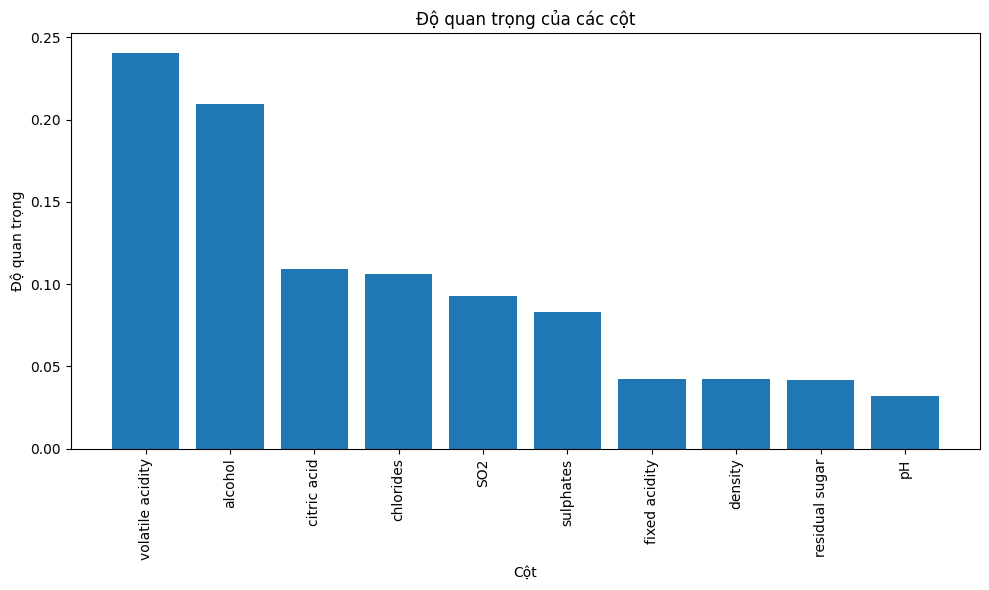

In [ ]:
# Xử dụng mô hình để tìm biến quan trọng
dt = DecisionTreeClassifier(max_depth= depth, random_state=42)
dt.fit(X_train,y_train)
score = dt.feature_importances_
# Hiển thị cột của từng độ quan trọng
for feature, importance in zip(X.columns, score):
    print(f'Cột {feature}: {importance}')

# Trực quan hóa độ quan trọng của các cột
indices = np.argsort(score)[::-1]
sorted_features = [X_train.columns[i] for i in indices]
sorted_importances = score[indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.xlabel('Cột')
plt.ylabel('Độ quan trọng')
plt.title('Độ quan trọng của các cột')
plt.tight_layout()
plt.show()

In [ ]:
# Xóa 4 cột có độ quan trọng thấp nhất
sorted_indices = np.argsort(score)[:4]
lowest_columns = X.columns[sorted_indices]

for column in lowest_columns:
    del data[column]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526 entries, 0 to 2525
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   volatile acidity  2526 non-null   float64
 1   citric acid       2526 non-null   float64
 2   chlorides         2526 non-null   float64
 3   sulphates         2526 non-null   float64
 4   alcohol           2526 non-null   float64
 5   SO2               2526 non-null   float64
 6   quality           2526 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 138.3 KB


In [ ]:
data.head()

,volatile acidity,citric acid,chlorides,sulphates,alcohol,SO2,quality
0,0.70,0.00,0.076,0.56,9.4,23.0,1
1,0.88,0.00,0.098,0.68,9.8,42.0,1
2,0.76,0.04,0.092,0.65,9.8,39.0,1
3,0.28,0.56,0.075,0.58,9.8,43.0,1
4,0.66,0.00,0.075,0.56,9.4,27.0,1


In [ ]:
# Chia tập dữ liệu train và test lần 2 (sau khi đã xóa 4 thuộc tính)
X_train, X_test, y_train, y_test = split_data(data)

# Mô hình logistic

In [ ]:
# Xác định các thuộc tính đầu vào
features = list(data.iloc[:,:-1].columns)

# Tạo 64 mô hình nhị phân khác nhau
np.random.seed(10)
random_model = np.random.choice([0, 1], size=(64, 6))

# Loại bỏ các hàng có toàn giá trị 0
random_model = random_model[~np.all(random_model == 0, axis=1)]

In [ ]:
random_model

array([[1, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1],
       [1, 0, 1, 1, 1, 1],
       [1, 0, 1, 0, 0, 0],
       [0, 1, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [1, 0, 1, 1, 0, 1],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 1, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 1],
       [1, 1, 1, 0, 1, 0],
       [1, 1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0],
       [1, 1, 0, 0, 0, 1],
       [0, 1, 1, 0, 1, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1, 0],
       [0, 1, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1],
       [1, 1, 0, 0, 1, 1],
       [0, 1, 1, 1, 0, 1],
       [0, 1, 0, 0, 1, 1],
       [0, 1, 1, 1, 0, 1],
       [1, 0, 1, 1, 1, 0],
       [1, 0, 0, 1, 1, 1],
 

In [ ]:
# Xây dựng mô hình hồi quy logistic cho từng mã mô hình
accuracies = []
# Mã hóa lại các biến được chọn
for code in random_model:
    selected_features = [features[i] for i in range(6) if code[i] == 1]

    X_train_df = pd.DataFrame(X_train, columns=features)
    X_test_df = pd.DataFrame(X_test, columns=features)

    X_train_selected = X_train_df.loc[:, selected_features]
    X_test_selected = X_test_df.loc[:, selected_features]

    # Áp dụng mô hình Logistic
    model = LogisticRegression(multi_class='multinomial')
    model.fit(X_train_selected, y_train)

    # Dự doán và đánh giá độ chính xác accuracy
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)

    # Lưu model và accuracy của 64 mô hình vào danh sách
    accuracies.append(accuracy)

In [ ]:
# Chọn mô hình có độ chính xác cao nhất từ các mô hình cuối cùng
best_final_model_index = np.argmax(accuracies)

best_final_model_code = random_model[best_final_model_index]

variables = [features[i] for i in range(6) if best_final_model_code[i] == 1]
print("Mô hình tốt nhất\n",variables)
print("Accuracy: ",random_model[best_final_model_index])

Mô hình tốt nhất
 ['volatile acidity', 'chlorides', 'sulphates', 'alcohol']
Accuracy:  [1 0 1 1 1 0]


In [ ]:
# Thêm cột quality
variables.append('quality')
data = data.loc[:,variables]

In [ ]:
data.head()

,volatile acidity,chlorides,sulphates,alcohol,quality
0,0.70,0.076,0.56,9.4,1
1,0.88,0.098,0.68,9.8,1
2,0.76,0.092,0.65,9.8,1
3,0.28,0.075,0.58,9.8,1
4,0.66,0.075,0.56,9.4,1


In [ ]:
# Lấy danh sách tên cột của 4 biến giải thích
labels = list(data.iloc[:,:-1].columns)

# Tách tập dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(data[labels], data['quality'], test_size=0.2, random_state=42)

In [ ]:
# Chuẩn hóa dữ liệu
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Lưu trình biến đổi
joblib.dump(sc, "scaler.pkl")

['scaler.pkl']

# Mô hình MLP

In [ ]:
# Xây dựng mô hình MLP
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', max_iter = 1000, random_state=42)
# Huấn luyện mô hình
mlp.fit(X_train, y_train)
# Dự đoán nhãn cho tập kiểm tra
mlp_y_pred = mlp.predict(X_test)

#Mô hình ANN

In [ ]:
#cấu hình mạng lưới nơ ron nhân tạo
ann = Sequential([Dense(192, activation="relu", input_shape=(X_train.shape[1],)),
                    Dense(128, activation="relu"),
                    Dense(3, activation="softmax")])
#biên dịch mạng lưới
ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#huấn luyện mạng lưới
ann.fit(X_train,y_train,epochs=50,validation_data=(X_test, y_test))

Epoch 1/50
64/64 [==============================] - 2s 20ms/step - loss: 0.8047 - accuracy: 0.6104 - val_loss: 0.7043 - val_accuracy: 0.6443
Epoch 2/50
64/64 [==============================] - 1s 9ms/step - loss: 0.7062 - accuracy: 0.6619 - val_loss: 0.6807 - val_accuracy: 0.6423
Epoch 3/50
64/64 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.6797 - val_loss: 0.6682 - val_accuracy: 0.6383
Epoch 4/50
64/64 [==============================] - 0s 4ms/step - loss: 0.6634 - accuracy: 0.6777 - val_loss: 0.6608 - val_accuracy: 0.6877
Epoch 5/50
64/64 [==============================] - 0s 4ms/step - loss: 0.6534 - accuracy: 0.6946 - val_loss: 0.6362 - val_accuracy: 0.6937
Epoch 6/50
64/64 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.7208 - val_loss: 0.6294 - val_accuracy: 0.7075
Epoch 7/50
64/64 [==============================] - 0s 4ms/step - loss: 0.6238 - accuracy: 0.7158 - val_loss: 0.6024 - val_accuracy: 0.7194
Epoch 8/50
64/64 [=

In [ ]:
# Dự đoán nhãn từ dữ liệu kiểm thử
y_pred = ann.predict(X_test)

# Chuyển đổi đầu ra dự đoán thành nhãn
ann_y_pred = np.argmax(y_pred, axis=1)

16/16 [==============================] - 0s 2ms/step


#RNN

In [ ]:
#Xây dựng mô hình RNN

rnn = tf.keras.Sequential()
rnn.add(tf.keras.layers.LSTM(32, input_shape=(X_train.shape[1],1)))
rnn.add(tf.keras.layers.Dropout(0.2))
rnn.add(tf.keras.layers.Dense(3, activation='linear'))

# Biên dịch mô hình
rnn.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# Huấn luyện mô hình
rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
64/64 [==============================] - 4s 16ms/step - loss: 1.2825 - accuracy: 0.3604 - val_loss: 0.6504 - val_accuracy: 0.3043
Epoch 2/50
64/64 [==============================] - 0s 6ms/step - loss: 0.4520 - accuracy: 0.3401 - val_loss: 0.3743 - val_accuracy: 0.4565
Epoch 3/50
64/64 [==============================] - 0s 6ms/step - loss: 0.3786 - accuracy: 0.3772 - val_loss: 0.3397 - val_accuracy: 0.4644
Epoch 4/50
64/64 [==============================] - 0s 6ms/step - loss: 0.3605 - accuracy: 0.3802 - val_loss: 0.3349 - val_accuracy: 0.4447
Epoch 5/50
64/64 [==============================] - 0s 6ms/step - loss: 0.3555 - accuracy: 0.3515 - val_loss: 0.3311 - val_accuracy: 0.4111
Epoch 6/50
64/64 [==============================] - 0s 6ms/step - loss: 0.3611 - accuracy: 0.3312 - val_loss: 0.3302 - val_accuracy: 0.4526
Epoch 7/50
64/64 [==============================] - 0s 6ms/step - loss: 0.3547 - accuracy: 0.3450 - val_loss: 0.3293 - val_accuracy: 0.4051
Epoch 8/50
64/64 [=

In [ ]:
# Dự đoán nhãn từ dữ liệu kiểm thử
y_pred1 = rnn.predict(X_test)

# Chuyển đổi đầu ra dự đoán thành nhãn
rnn_y_pred = np.argmax(y_pred1, axis=1)

16/16 [==============================] - 0s 2ms/step


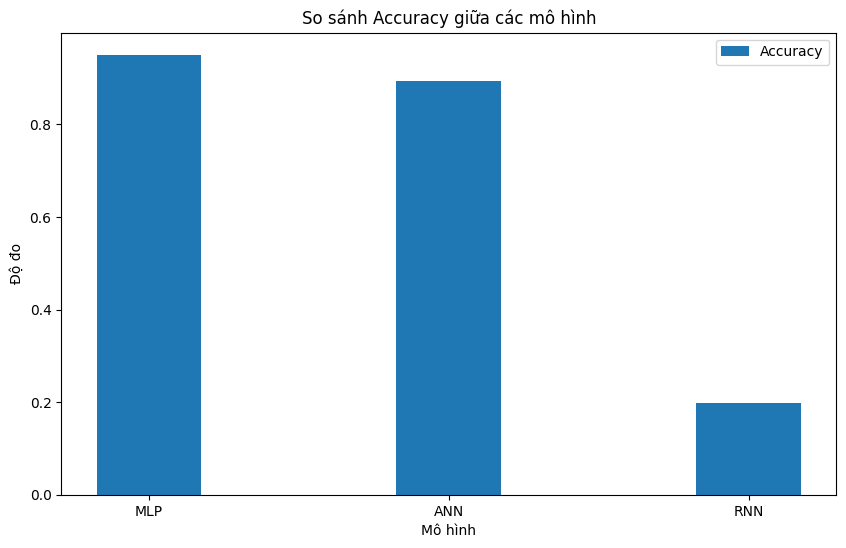

In [41]:
models = ['MLP', 'ANN', 'RNN']

accuracies = []
y_preds = [mlp_y_pred, ann_y_pred, rnn_y_pred]

# In sai số trung bình và báo cáo phân loại của từng mô hình
for model, y_pred in zip(models, y_preds):
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Accuracy của các mô hình
accuracy_scores = accuracies

# Tạo mảng các chỉ số cho các mô hình
x_indexes = np.arange(len(models))

# Kích thước của mỗi cột
bar_width = 0.35

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

plt.bar(x_indexes, accuracy_scores, width=bar_width, label='Accuracy')

plt.xlabel('Mô hình')
plt.ylabel('Độ đo')
plt.title('So sánh Accuracy giữa các mô hình')
plt.xticks(x_indexes, models)
plt.legend()
plt.show()

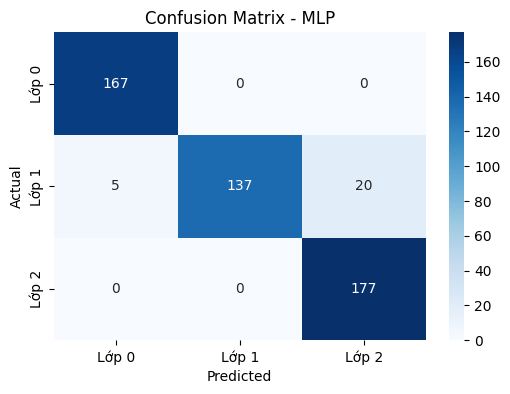

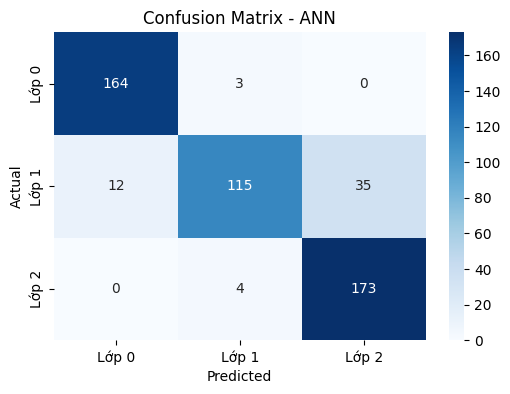

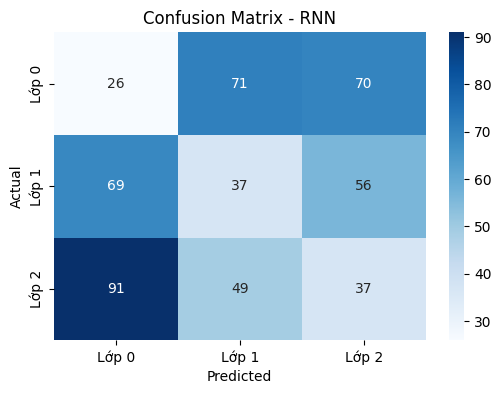

In [ ]:
# Create a list of predicted labels for each model
y_pred_list = [mlp_y_pred, ann_y_pred, rnn_y_pred]

# Define class labels
class_labels = ['Lớp 0', 'Lớp 1', 'Lớp 2']

# Define model names
model_names = ['MLP', 'ANN', 'RNN']

# Plot confusion matrices for each model
for i, y_pred in enumerate(y_pred_list):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_names[i]}')
    plt.show()

In [42]:
models = ['MLP', 'ANN', 'RNN']
y_preds = [mlp_y_pred, ann_y_pred, rnn_y_pred]

# In sai số trung bình và báo cáo phân loại của từng mô hình
for model, y_pred in zip(models, y_preds):
    report = classification_report(y_test, y_pred)
    print(f"Báo cáo phân loại {model}:\n{report}")
    print()

Báo cáo phân loại MLP:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       167
           1       1.00      0.85      0.92       162
           2       0.90      1.00      0.95       177

    accuracy                           0.95       506
   macro avg       0.96      0.95      0.95       506
weighted avg       0.95      0.95      0.95       506


Báo cáo phân loại ANN:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       167
           1       0.94      0.71      0.81       162
           2       0.83      0.98      0.90       177

    accuracy                           0.89       506
   macro avg       0.90      0.89      0.89       506
weighted avg       0.90      0.89      0.89       506


Báo cáo phân loại RNN:
              precision    recall  f1-score   support

           0       0.14      0.16      0.15       167
           1       0.24      0.23      0.23       162
    

In [ ]:
#@title Lưu mô hình vào tệp tin
joblib.dump(mlp, "wine_model.pkl")

['wine_model.pkl']